In [62]:
import numpy as np, pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
from skimage import color, transform, io
from scipy import interpolate, optimize
from image_utils import crop_array, img_fold, pixel_coords_on_line

In [2]:
XYZ_wl = pd.read_table("./color_matching_functions.txt",delimiter=" ",header=0)

def rho(band,wl):
    vectors = {'r': [0.021592459, 0.020293111, 0.021807906, 0.023803297, 0.025208132, 0.025414957, 0.024621282, 0.020973705, 0.015752802, 0.01116804, 0.008578277, 0.006581877, 0.005171723, 0.004545205, 0.00414512, 0.004343112, 0.005238155, 0.007251939, 0.012543656, 0.028067132, 0.091342277, 0.484081092, 0.870378324, 0.939513128, 0.960926994, 0.968623763, 0.971263883, 0.972285819, 0.971898742, 0.972691859, 0.971734812, 0.97234454, 0.97150339, 0.970857997, 0.970553866, 0.969671404],
               'g': [0.010542406, 0.010878976, 0.011063512, 0.010736566, 0.011681813, 0.012434719, 0.014986907, 0.020100392, 0.030356263, 0.063388962, 0.173423837, 0.568321142, 0.827791998, 0.916560468, 0.952002841, 0.964096452, 0.970590861, 0.972502542, 0.969148203, 0.955344651, 0.892637233, 0.5003641, 0.116236717, 0.047951391, 0.027873526, 0.020057963, 0.017382174, 0.015429109, 0.01543808, 0.014546826, 0.015197773, 0.014285896, 0.015069123, 0.015506263, 0.015545797, 0.016302839],
               'b': [0.967865135, 0.968827912, 0.967128582, 0.965460137, 0.963110055, 0.962150324, 0.960391811, 0.958925903, 0.953890935, 0.925442998, 0.817997886, 0.42509696, 0.167036273, 0.078894327, 0.043852038, 0.031560435, 0.024170984, 0.020245519, 0.01830814, 0.016588218, 0.01602049, 0.015554808, 0.013384959, 0.012535491, 0.011199484, 0.011318274, 0.011353953, 0.012285073, 0.012663188, 0.012761325, 0.013067426, 0.013369566, 0.013427487, 0.01363574, 0.013893597, 0.014025757]}
    x = np.arange(380,731,10)
    r = interpolate.interp1d(x,vectors[band])
    return r(wl)

In [3]:
ztau = io.imread("./ztau.jpg")
castor = io.imread("./castor.jpg")

In [156]:
def rgbplot(pxl_line):
    x = np.arange(0,pxl_line.shape[1])
    plt.plot(x,pxl_line[0,:,0],"r-")
    plt.plot(x,pxl_line[0,:,1],"g-")
    plt.plot(x,pxl_line[0,:,2],"b-")
    plt.xlabel("Pixel index")
    plt.ylabel("Color value")
    plt.show()
    
def intensityplot(pxl_line):
    x = np.arange(0,pxl_line.shape[1])
    plt.plot(x,np.sum(pxl_line[0],axis=1),"-")
    plt.xlabel("Pixel index")
    plt.ylabel("Sum of color value")
    plt.show()
    
def planck(wavelength,T,amp): #in nm
    h = 6.626e-34 # Planck's constant, J*s
    c = 299792458 # speed of light, m/s
    k = 1.38064852e-23 # Boltzmann constant, J/K
    B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law
    return B # W/m^2/nm

def wien(T):
    b = 2.897771955e-3 # Wien's displacement constant, in m*K
    λ_max = (b/T)*1e9 # Wien's Law, with λ converted from nm
    return λ_max # in K

class Spectrum:
    def __init__(self,pxls,colorspace="rgb"):
        self.axis_calibrated = False
        self.flux_calibrated = False
        if pxls.shape[0]==1:
            self.pxls = pxls
        elif pxls.shape[1]==1 and pxls.shape[0]>1:
            self.pxls = pxls.T
        else:
            self.pxls = img_fold(crop_array(pxls))
        self.x = np.arange(self.pxls.shape[1])
        if colorspace == "rgb":
            self.rgb = self.pxls
            self.hsv = color.rgb2hsv(self.pxls)
            self.xyz = color.rgb2xyz(self.pxls)
        elif colorspace == "hsv":
            self.rgb = color.hsv2rgb(self.pxls)
            self.hsv = self.pxls
            self.xyz = color.hsv2xyz(self.pxls)
        self.intensities = np.sum(self.pxls[0],axis=1)
        
    def calibrate_axis(self,pxl1,wl1,pxl2,wl2):
        stepsize = (wl2 - wl1) / (pxl2 - pxl1)
        start = wl1 - (stepsize * pxl1)
        end = start+stepsize*self.pxls.shape[1]
        self.x = np.arange(start,end,stepsize)
        self.axis_calibrated = True
        
    def calibrate_flux(self,pxl_intensity,mag,system="AB"):
        ref_flux = 3631*10**(-mag/2.5)
        self.intensities *= ref_flux/pxl_intensity
        self.flux_calibrated = True
        
    def plot(self,**kwargs):
        plt.plot(self.x,self.intensities)
        plt.show()
        
    def fit_bb(self):
        if self.axis_calibrated:
            if self.flux_calibrated:
                fit_params, cov_mat = optimize.curve_fit(planck, self.x, self.intensities, p0=[10000,1e-25])
                uncertainties = np.sqrt(np.diag(cov_mat))
            else:
                fit_params, cov_mat = optimize.curve_fit(planck, self.x, self.intensities, p0=[10000,1e-15])
                uncertainties = np.sqrt(np.diag(cov_mat))
            return {"Teff":fit_params[0],"scale":fit_params[1],"e_Teff":uncertainties[0],"e_scale":uncertainties[1]}
        else:
            return None

In [157]:
test = Spectrum(ztau)
test.calibrate_axis(0,70,468,656)
test.calibrate_flux(4.25,30)
test.fit_bb()

{'Teff': 10484.050152094482,
 'scale': 9.780295457922962e-23,
 'e_Teff': 45.036993655988105,
 'e_scale': 1.9883892202311907e-24}

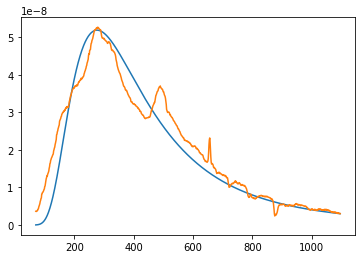

In [158]:
plt.plot(test.x,planck(test.x,10484,1e-22))
test.plot()

In [166]:
test2 = Spectrum(castor[:,200:1000,:])
test2.calibrate_axis(0,1,236,282)
test2.calibrate_flux(60,30)
test2.fit_bb()

<ipython-input-156-a37d6fc61502>:21: RuntimeWarning: overflow encountered in exp
  B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law


{'Teff': 9675.790092233583,
 'scale': 4.4475588666691814e-23,
 'e_Teff': 60.93200807680198,
 'e_scale': 1.3290891906033764e-24}

<ipython-input-156-a37d6fc61502>:21: RuntimeWarning: overflow encountered in exp
  B = amp*((2*h*(c**2))/((wavelength*0.000000001)**5))*(np.exp((h*c)/((wavelength*0.000000001)*k*T))-1)**(-1) # Planck's Law


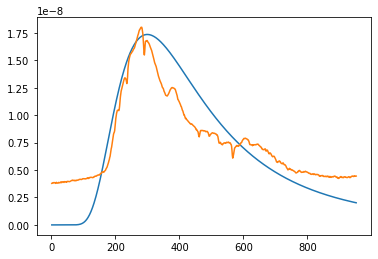

In [167]:
plt.plot(test2.x,planck(test2.x,9675,5e-23))
test2.plot()